# MOD600 - Project 1 - Multiphase Flow Simulation using Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1

Define the flux function f(s):

In [2]:
def f(s,M,nw,no):
    krw = np.power(s,nw)
    kro = np.power((1-s),no)
    f = krw/(krw+M*kro)
    return f

Parameters:

In [3]:
#array of different viscosity ratios M
M = np.arange(0.5,5.5,0.5)     

#corey exponents
nw = 3
no = 2

#array of 0<s<1 for plotting
s = np.arange(0,1,0.001)        

#array of 0<x<1 for initial data 
x = np.arange(0,1.001,0.001)   

#x limit for initial data
x0 = 0.1        

#definition of initial data (not used)
s0 = np.where((x<x0),1,0)       

Plot:

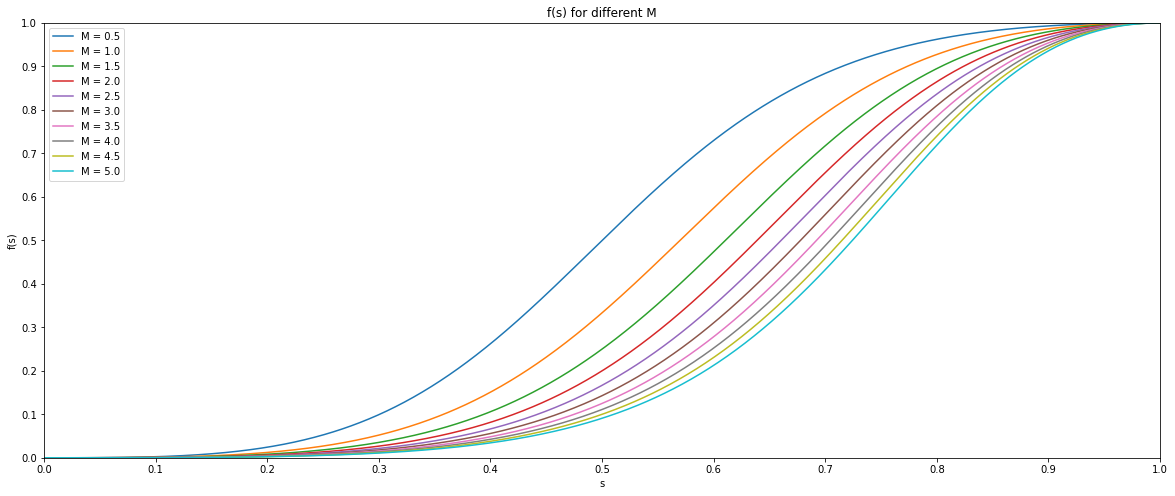

In [4]:
plt.figure(figsize = (20,8))
for m in M: 
    plt.plot(s,f(s,m,nw,no),label=str('M = '+str(m)))
    plt.xlabel('s')
    plt.ylabel('f(s)')
    plt.title('f(s) for different M')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend()


The plot above shows the flux function f(s) over s for different viscosity ratios M between M = 0.5 and M = 5. Note that this plot is independant of the initial data. A smaller viscosity ratio M leads to an earlier increase of the flux f(s) in respect of the saturation s.

## Task 2

### (i)

To obtain the exact solution at T = 0.5 we use the first derivative of f in terms of s to find the front-height sf using the tangent on f(s) through (0,0) and to calculate the speed at which the front and the saturation distribution behind the front move.

In [5]:
def f_deriv(s,M,nw,no):
    f_deriv = (nw*np.power(s,(nw-1))*M*np.power((1-s),no)+M*no*np.power((1-s),(no-1))*np.power(s,nw))/np.square(np.power(s,nw)+M*np.power((1-s),no))
    return f_deriv
    

Finding the front-height sf using a tangent on f(s) through (0,0):

In [6]:
def sf_func(M,nw,no,sf_low_lim = 0.2, d_sf=0.0001, tol = 0.0005):
    sf_array = np.arange(sf_low_lim,1,d_sf)
    f_sf = {}
    for sf in sf_array:
        f_sf[sf] = f(sf,M,nw,no)
        m = f_sf[sf]/sf
        if m-tol < f_deriv(sf,M,nw,no) < m+tol:
            break
    return sf


Defining the speed for the front and the saturation distribution behind the front:

In [7]:
def speed(s,M,nw,no):
    front_height = sf_func(M,nw,no)
    front_speed = f_deriv(front_height,M,nw,no)
    speed = np.where(s<=front_height,front_speed,f_deriv(s,M,nw,no))
    return speed

Defining a function to calculate the position of the front and saturation distribution behind the front at a given time, using the x limit for the initial data, before which the saturation is 1:

In [8]:
def x_func(s,t,M,nw,no,x0=0.1):
    x = x0 + speed(s,M,nw,no)*t
    return x

Parameters:

In [9]:
#arrays for plotting
x_analyt = np.arange(0,1.001,0.001)
s_analyt = np.arange(0,1.001,0.001)

#time T and viscosity ratios M
T = 0.5
M = np.arange(0.5,5.5,0.5)

#corey exponents
nw = 3
no = 2

#initial condition
x0 = 0.1
s0 = np.where((x<x0),1,0) #not used

Plot:

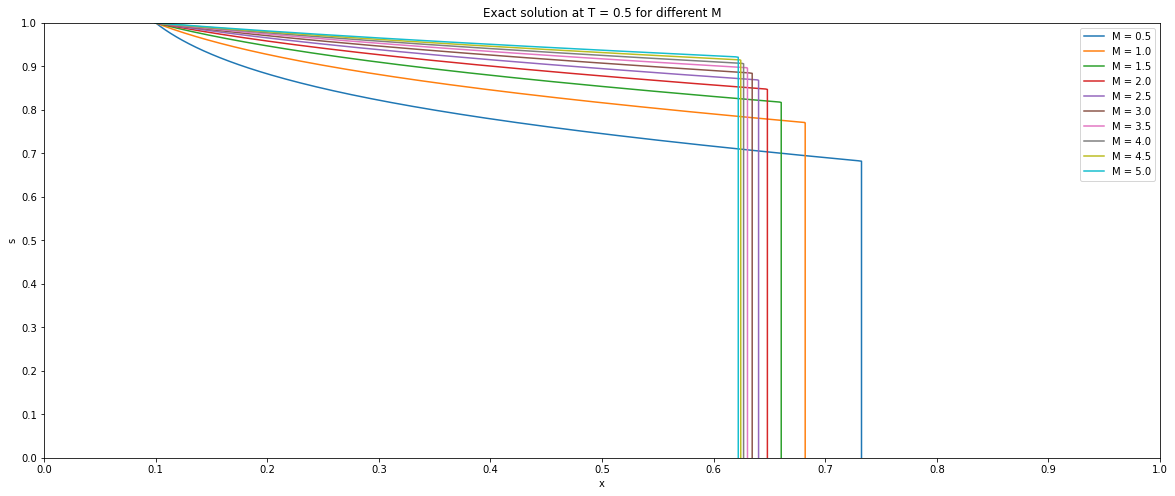

In [10]:
plt.figure(figsize = (20,8))
for m in M: 
    plt.plot(x_func(s_analyt,T,m,nw,no,x0),x_analyt,label=str('M = '+str(m)))
    plt.xlabel('x')
    plt.ylabel('s')
    plt.title('Exact solution at T = '+str(T)+' for different M')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend()

The plot above shows, that a smaller viscosity ratio M (which leads to a earlier increase of the flux f(s) with respect to the saturation s, as observed previously) results in a smaller front height sf and faster front speed.

### (ii)

#### Define the function for the numerical solution

In [11]:
def s_num(M_cells = 100, N_time = 250, T = 0.5, a_relax=0.9, M=1, nw = 3, no = 2, x0=0.1):
    #discretisation of x
    x_cells = np.linspace(-1/M_cells,1+1/M_cells,M_cells)
    dx = 1/M_cells

    #initial condition
    s0 = np.where((x_cells<x0),1,0)
    
    #discretisation of time
    T_array = np.linspace(0,T,N_time)
    dt = T/N_time

    #correction factor a for stability (CFL-condition)
    a = a_relax*dx/dt

    #initialize s matrix
    s = np.zeros((N_time,M_cells))

    #apply initial condition
    s[0] = s0

    #numerical scheme
    for n in range(len(T_array)-1):

        #confirm valid correction factor a for stability 
        max_speed = np.max(np.abs(f_deriv(s[n],M,nw,no)))
        if a < max_speed:
            print('Error: a is smaller than the maximum speed. Increase N_time or decrease M_cells')
            break

        #central based flux
        for j in range(len(x_cells)-1):  
            s[n+1,j] = s[n,j]-(dt/dx)*((0.5*(f(s[n,j],M,nw,no)+f(s[n,j+1],M,nw,no))-(a/2)*(s[n,j+1]-s[n,j]))-(0.5*(f(s[n,j],M,nw,no)+f(s[n,j-1],M,nw,no))-(a/2)*(s[n,j]-s[n,j-1])))
        
        #left boundary condition --> constant flowrate of s=1
        s[n+1] = np.where((x_cells<x0),1,s[n+1])

    return s,x_cells,T_array

#### Observe the numerical solution compared to the exact solution at different timesteps

Parameters:

In [12]:
M_cells = 500                           #number of cells
n_time = int(1.7 * M_cells)             #number of timesteps (1.7*M_cells is a reasonably good factor for a stable simulation with the given parameters gotten by trial and error)
T = 0.5                                 #desired end time of the simulation
a_relax = 0.9                           #relaxation factor for the correction factor a for stability (CFL-condition)
M=1                                     #viscosity ratio
nw = 3                                  #corey exponent for water
no = 2                                  #corey exponent for oil
x_analyt = np.arange(0,1.001,0.001)     #x array for analytical solution
s_analyt = np.arange(0,1.001,0.001)     #s array for analytical solution

Plot:

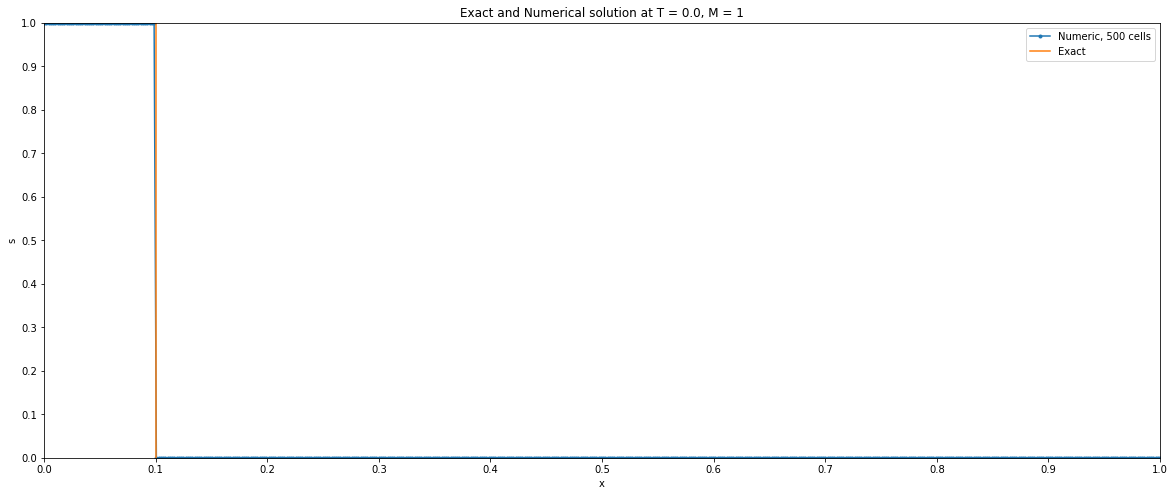

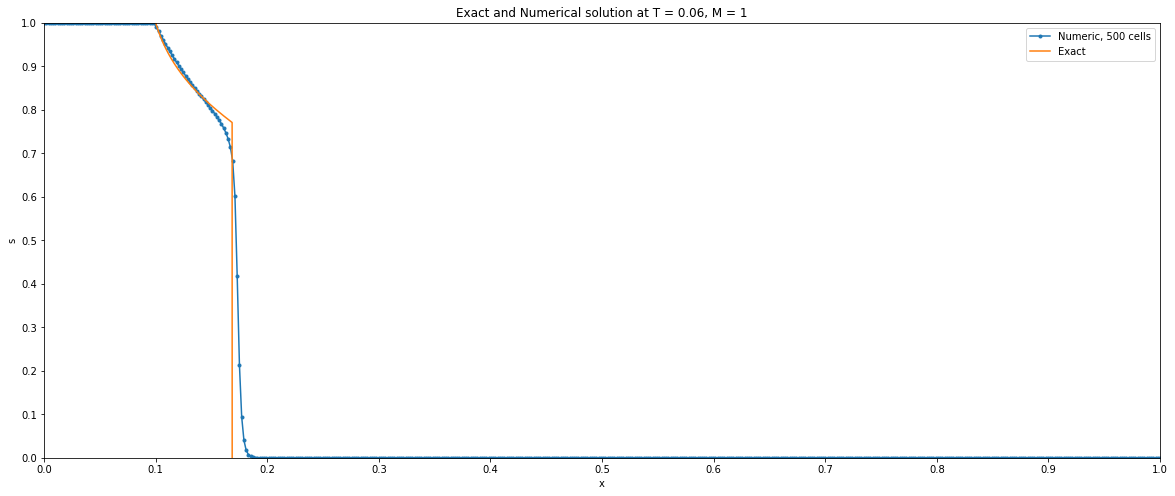

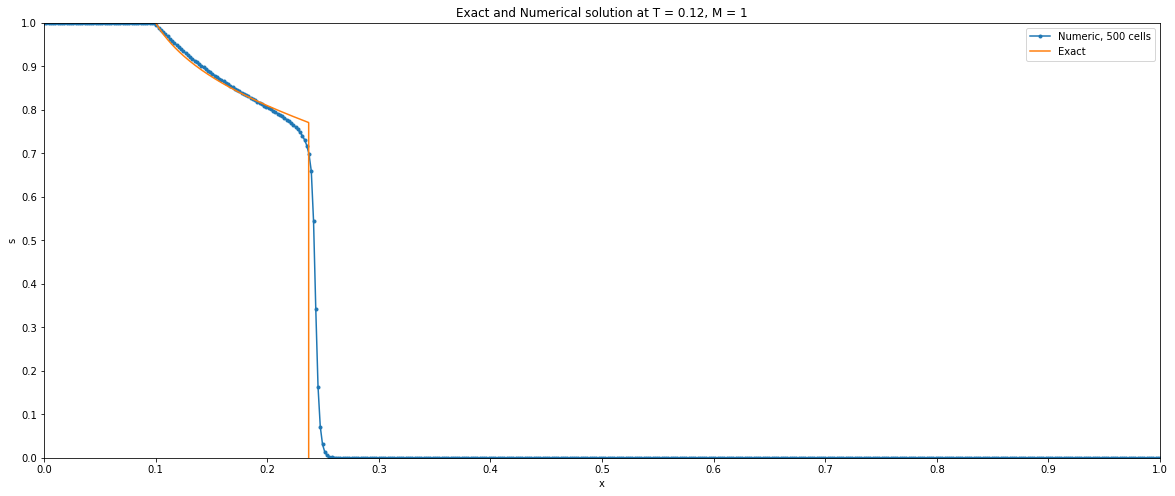

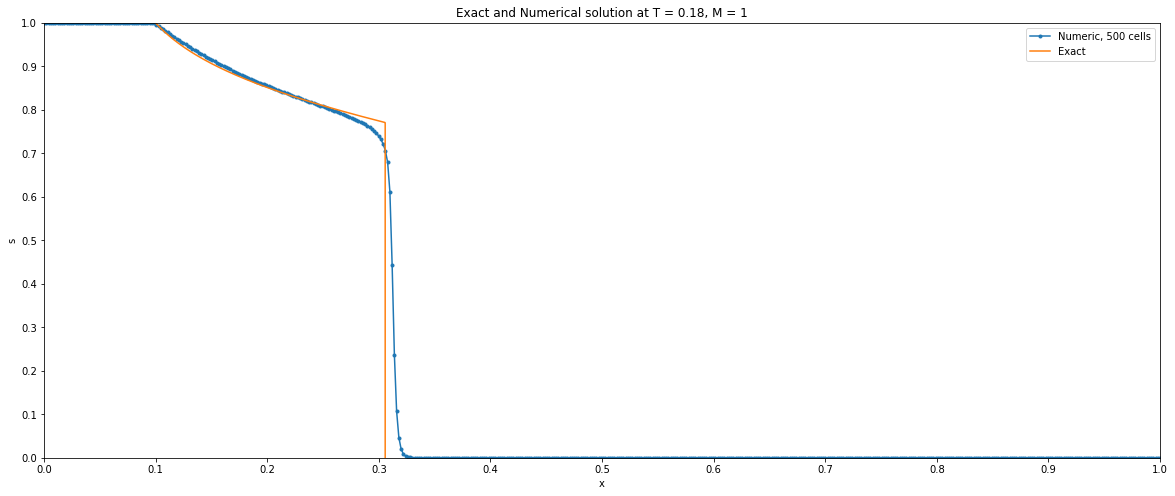

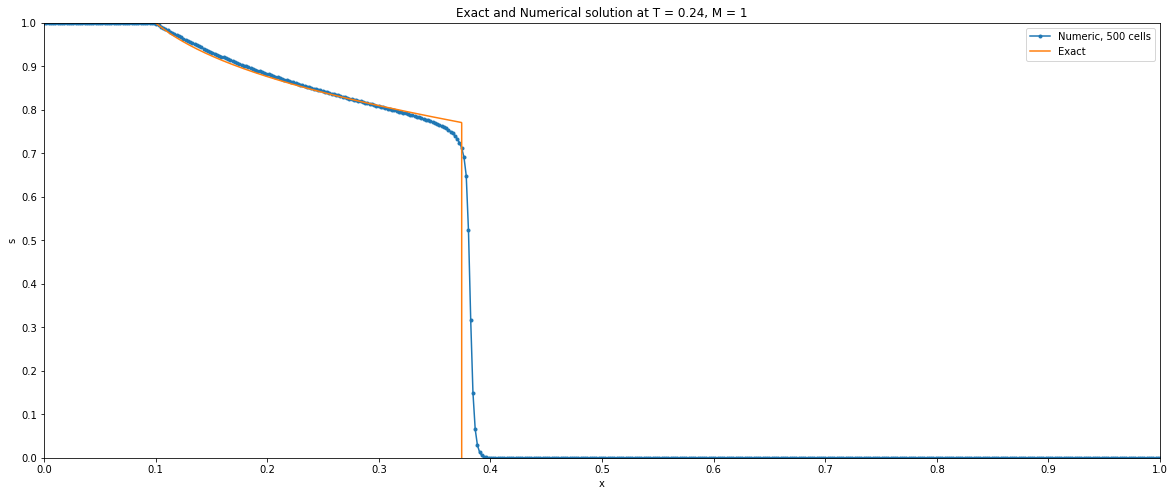

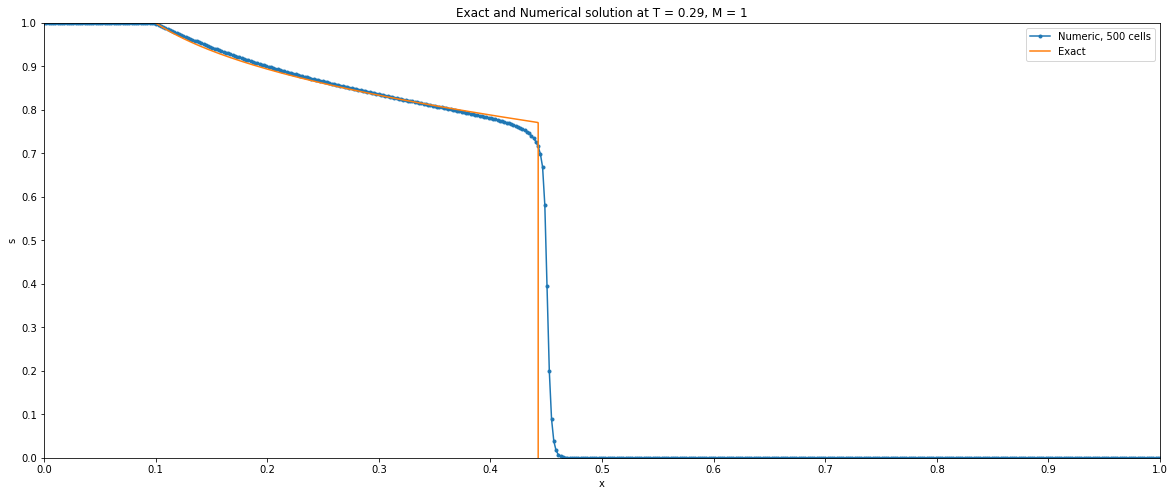

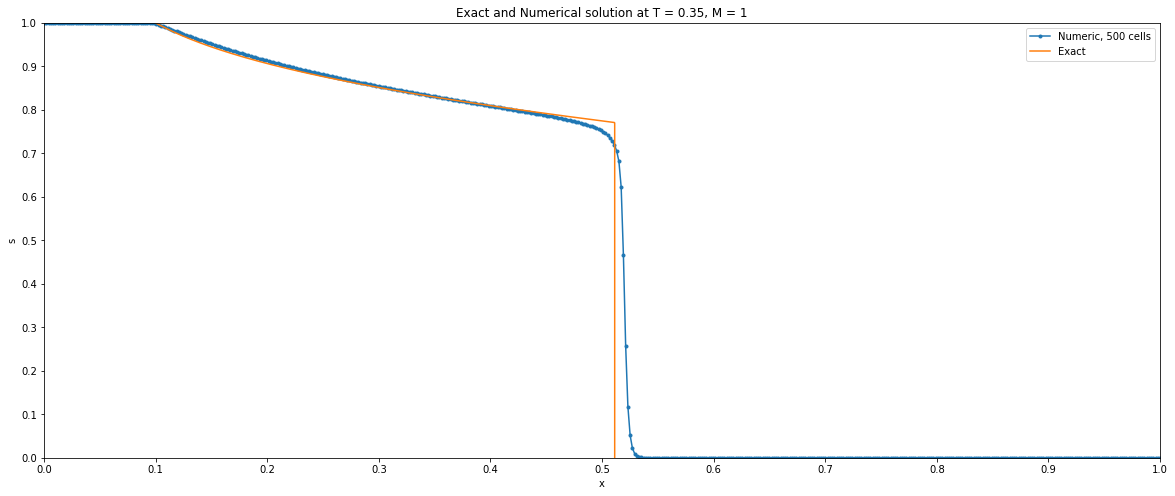

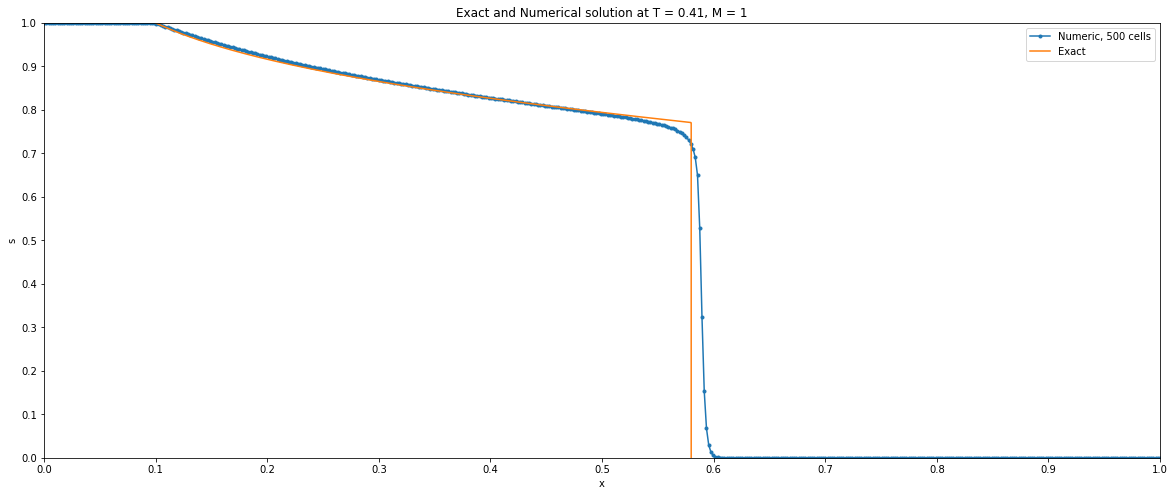

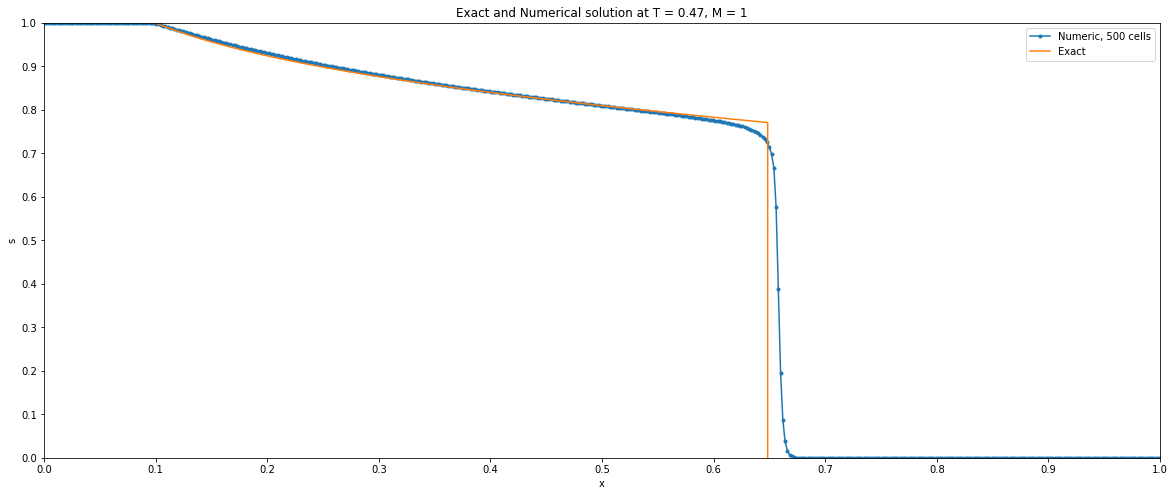

In [13]:

s,x_cells,T_array = s_num(M_cells,n_time,T,a_relax,M,nw,no)

for t in range(len(T_array)):
    if t%100 ==0:
        plt.figure(figsize = (20,8))
        plt.plot(x_cells,s[t],'.-',label='Numeric, '+str(M_cells)+' cells')
        plt.plot(x_func(s_analyt,T_array[t],M,nw,no),x_analyt,label='Exact')
        plt.xlabel('x')
        plt.ylabel('s')
        plt.title('Exact and Numerical solution at T = '+str(np.round(T_array[t],2))+str(', M = '+str(M)))
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks(np.arange(0,1.1,0.1))
        plt.yticks(np.arange(0,1.1,0.1))
        plt.legend()
        plt.show()

The result and behavior over time of the numerical solution agrees with the exact solution.

#### Sensibility on gridsize

Parameters:

In [14]:
M_cells = [10,20,50,100,500,1000]

T = 0.5 
a_relax = 0.9
M=1
nw = 3
no = 2
x_analyt = np.arange(0,1.001,0.001)
s_analyt = np.arange(0,1.001,0.001)

Plot:

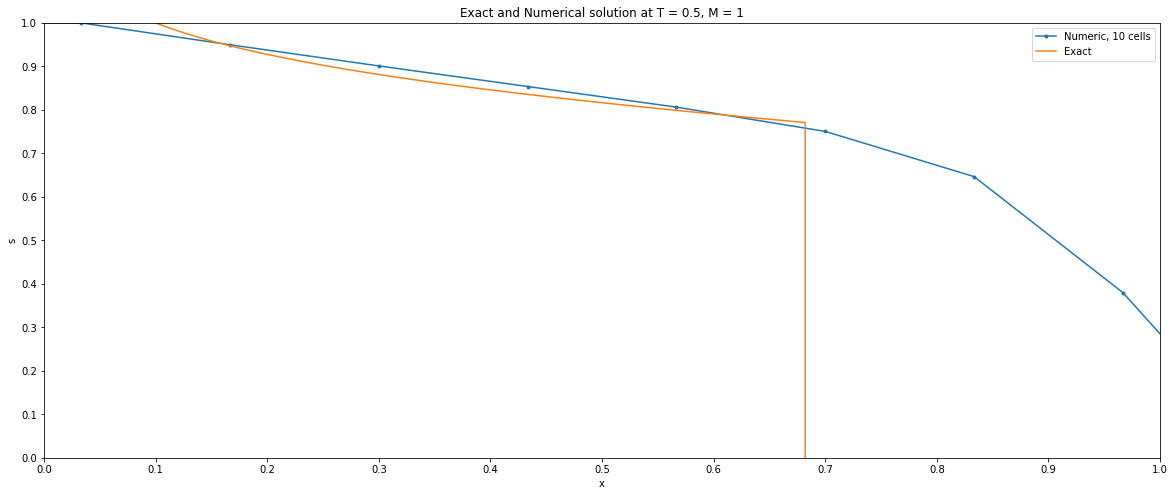

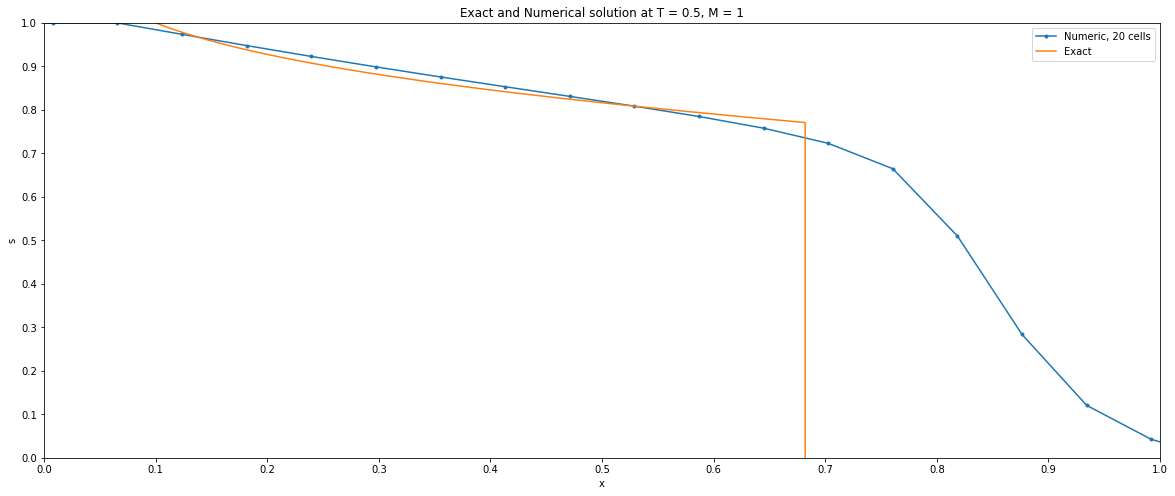

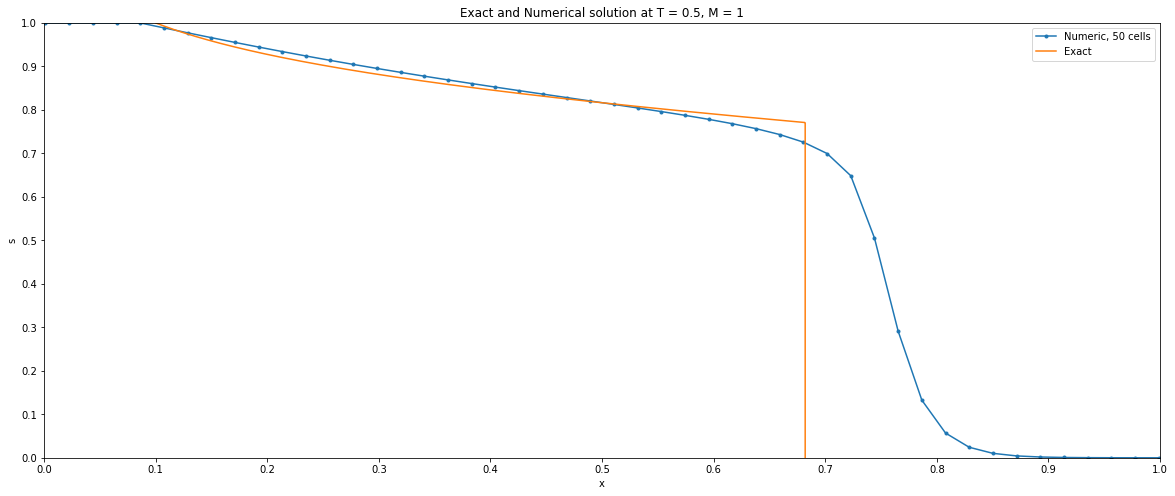

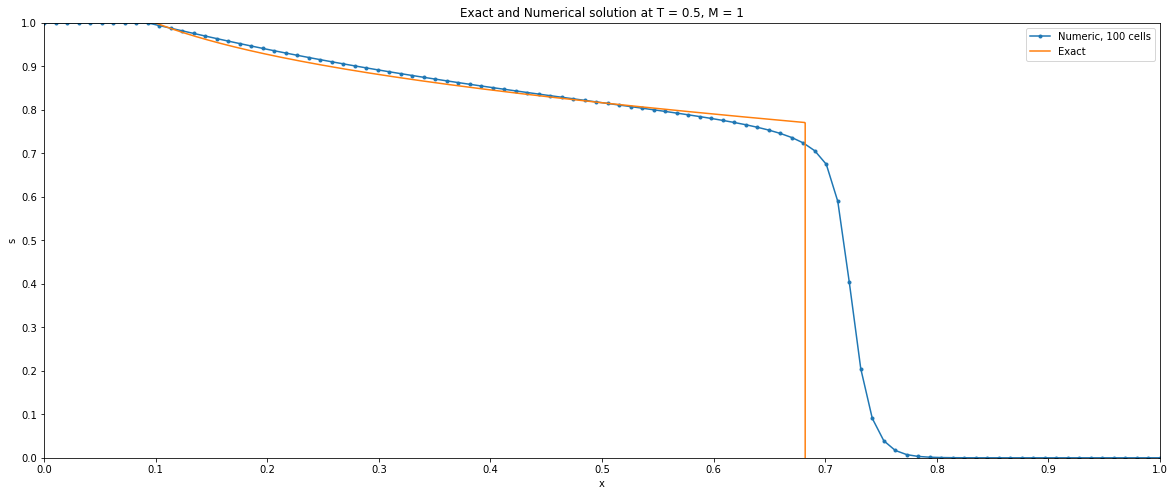

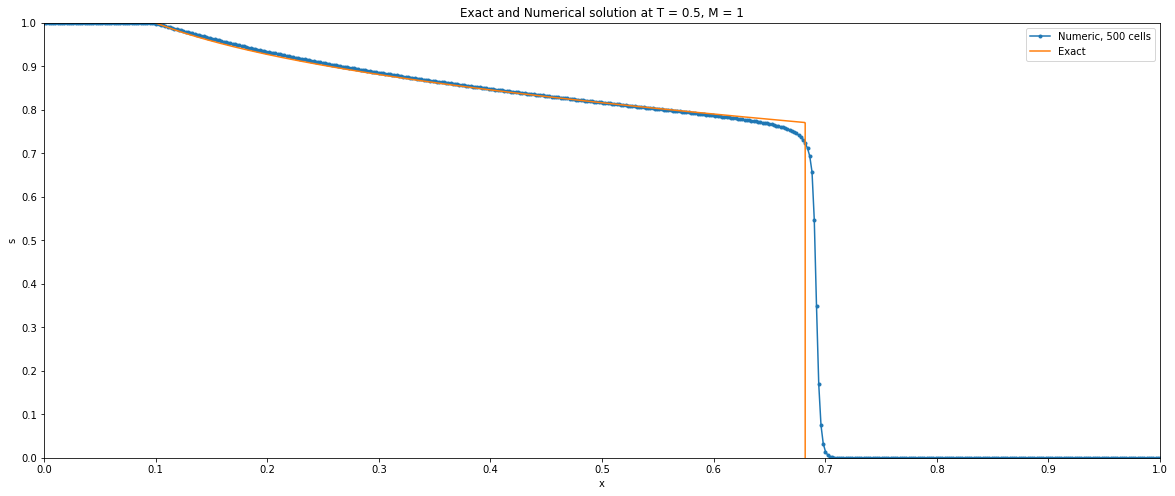

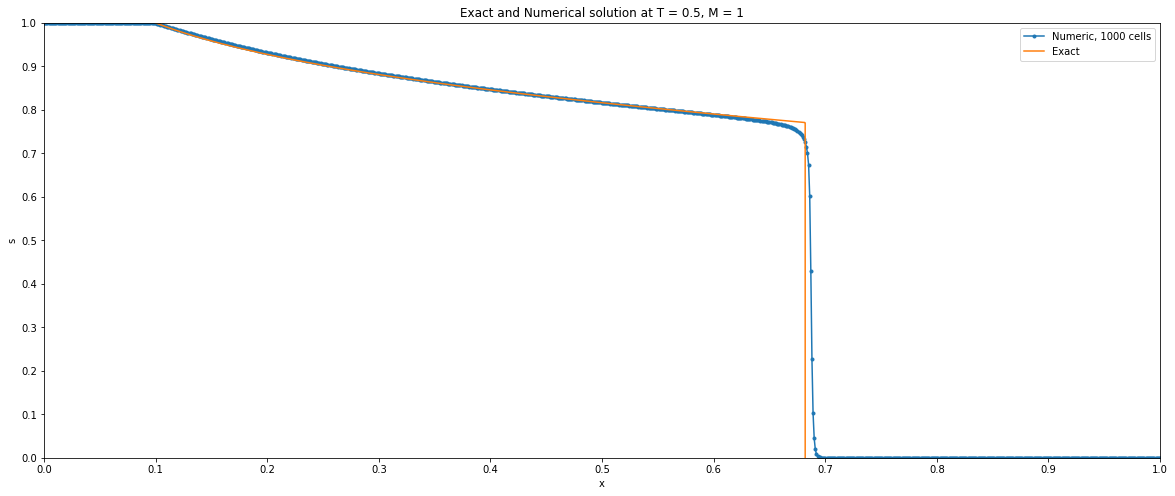

In [15]:
for m_cells in M_cells:
    n_time = int(1.7 * m_cells)
    s,x_cells,T_array = s_num(m_cells,n_time,T,a_relax,M,nw,no)
    
    plt.figure(figsize = (20,8))
    
    plt.plot(x_cells,s[-1],'.-',label='Numeric, '+str(m_cells)+' cells')
    plt.plot(x_func(s_analyt,T,M,nw,no),x_analyt,label='Exact')
    plt.xlabel('x')
    plt.ylabel('s')
    plt.title('Exact and Numerical solution at T = '+str(T)+str(', M = '+str(M)))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend()
    plt.show()


About 500 cells are needed to get a reasonably good solution.

#### Sensibility on M

In [16]:
M_cells = 500
N_time = int(1.7 * M_cells)
T = 0.5 
a_relax = 0.9
M = [0.5,1,2,3.5,5]
nw = 3
no = 2
x_analyt = np.arange(0,1.001,0.001)
s_analyt = np.arange(0,1.001,0.001)

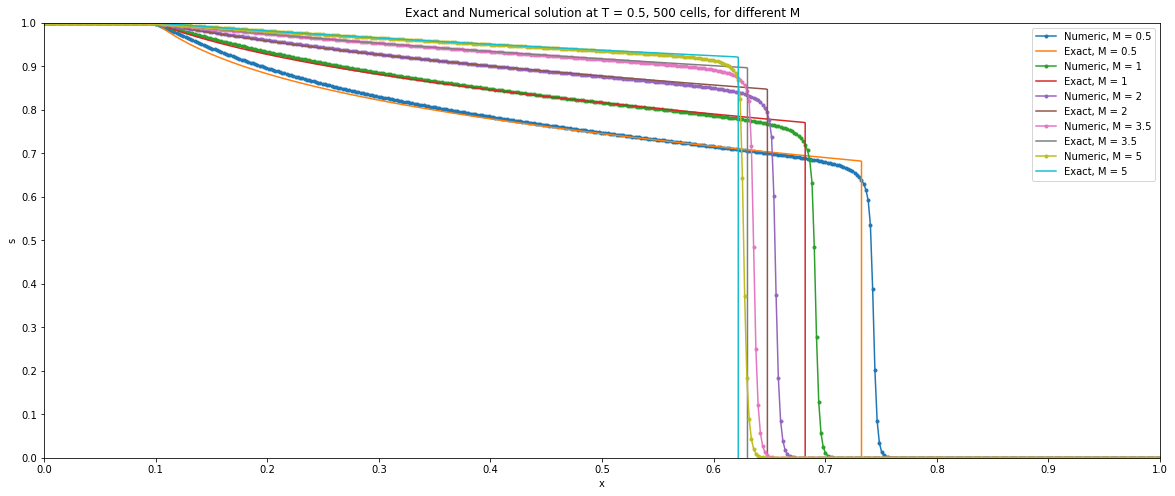

In [17]:
plt.figure(figsize = (20,8))
for m in M: 
    s,x_cells,T_array = s_num(M_cells,N_time,T,a_relax,m,nw,no)
    plt.plot(x_cells,s[-2],'.-',label='Numeric, M = '+str(np.round(m,2)))
    plt.plot(x_func(s_analyt,T,m,nw,no),x_analyt,label=str('Exact, M = '+str(np.round(m,2))))
    plt.xlabel('x')
    plt.ylabel('s')
    plt.title('Exact and Numerical solution at T = '+str(T)+', '+str(M_cells)+' cells, for different M')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend()
plt.show()

The numerical solution agrees with the exact solution in that a smaller viscosity ratio M (which leads to a earlier increase of the flux f(s) with respect to the saturation s, as observed previously) results in a smaller front height sf and faster front speed.

## Task 3

### Part 1:

#### (i) to (v):

See pdf

#### Plot for (v):

Parameters:

In [18]:
nw = 1
no = 1
M = 1
s = np.arange(0,1,0.001)

New flux function g(s):

In [19]:
def g(s,M,nw,no):
    krw = np.power(s,nw)
    kro = np.power((1-s),no)
    g = -krw*kro/(krw+M*kro)
    return g

And it´s derivative in respect of s:

In [20]:
def g_deriv(s,M,nw,no):
    g_deriv = -(((np.power(s,nw)+M*np.power((1-s),no))*(nw*np.power(s,(nw-1))*np.power(1-s,no))-np.power(s,nw)*no*np.power((1-s),(no-1)))-(nw*np.power(s,(nw-1))-M*no*np.power((1-s),(no-1)))*np.power(s,nw)*np.power((1-s),no))/(np.square(np.power(s,nw)+M*np.power((1-s),no)))
    return g_deriv

Plot:

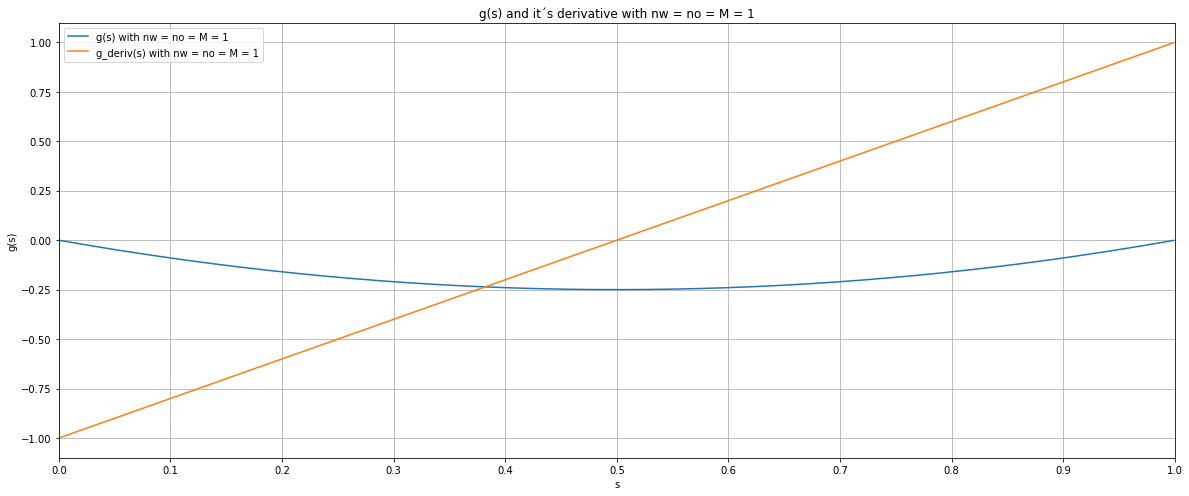

In [22]:
plt.figure(figsize = (20,8))

plt.plot(s,g(s,M,nw,no),label=str('g(s) with nw = no = M = '+str(M)))
plt.plot(s,g_deriv(s,M,nw,no),label=str('g_deriv(s) with nw = no = M = '+str(M)))

plt.xlabel('s')
plt.ylabel('g(s)')
plt.title(str('g(s) and it´s derivative with nw = no = M = '+str(M)))
plt.xlim(0,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.legend()
plt.grid()
plt.show()


The plot above shows that g(s) with nw = no = M = 1 is convex for 0 < s < 1.

### Part 2:

See pdf